# Building an Image Processing Toolchain with Planet APIs

With the Planet V2 Orders API, Planet users can construct processing toolchains on Planet's cloud. In this example we'll demonstrate, step-by-step, how to link multiple processing tools together into a single pipeline. 

An outline of the processing workflow will follow:

* Search for imagery using custom filters (geometry, date and cloud filters)

* Clip images to an area of interest

* Run a band math operation on those clipped images to calculate NDVI

* Deliver NDVI output to an S3 bucket and set up automatic notifications via webhooks

This example will use two Planet APIs. The first step searching and filtering Planet imagery will use the Planet Data API. The second step, processing and delivering Planet imagery will be handled by the Orders V2 API. 

In [1]:
import json
import time
import os
import folium
import requests
import sys
import gdal
import matplotlib.pyplot as plt
import importlib
import numpy as np
from IPython.display import Image
from requests import Session

#import relative packages
import sys
sys.path.append('..')
from utilities import post_to_data_api, post_to_orders_v2

### Construct Data Filters

First we want to create a search using the [Planet Data API](https://developers.planet.com/docs/api/searches-filtering/). The search we'll construct will be based on 3 filters:

* Geometry filter (to refine results to our area of interest)

* Date filter (to constrict results to the particular time of interest)

* Cloud filter (to filter out cloudy images)

**Geometry Filter**

To start constructing our Geometry filter, we'll load a geojson polygon that contains coordinates defining our AOI. If you'd like to define your own AOI, a good place to create a geojson is [geojson.io](https://geojson.io).

In [2]:
#First we need to open our geojson
aoi_fpath = r"data/salinas.geojson"
with open(aoi_fpath) as f:
    geom = json.load(f)

print(geom)

{u'type': u'Polygon', u'coordinates': [[[-121.52230739593504, 36.61614766140489], [-121.5064287185669, 36.59558067176291], [-121.49973392486572, 36.597475682390936], [-121.49999141693114, 36.60012861907971], [-121.49964809417725, 36.600852131435325], [-121.48685932159422, 36.60367720994241], [-121.49351119995116, 36.60915481126719], [-121.49291038513185, 36.60984379017978], [-121.50067806243895, 36.617181033751066], [-121.50625705718994, 36.61962662645977], [-121.51187896728514, 36.618972179675175], [-121.51883125305176, 36.61814550211168], [-121.52277946472168, 36.61707769713968], [-121.52230739593504, 36.61614766140489]]]}


We can plot the coordinates to view the area in the map below. The area we are intersted in is in the Salinas Valley in California, one of the most productive agricultural areas in California. A diversity of crops are grown in the Salinas valley including lettuce, broccoli, peppers and numerous others. 

Notice that our AOI is not a perfect rectangular image strip. Which is why we'll 'clip' the PlanetScope scenes to this area. Clipping gives us only the information (pixels) we're interested in and reduces the processing time for other operations that might be run after the image is downloaded. Clipping will also reduce your download quota and is recommended as best practice when working with Planet Imagery. 

In [3]:
#display geojson (for some reason coordinates are reversed?)
display_map = folium.Map(location=[geom['coordinates'][0][0][1], geom['coordinates'][0][0][0]], tiles='Stamen Terrain', zoom_start=13)
folium.GeoJson(geom, name='geojson').add_to(display_map)
display_map

Filters in the Planet Data API are defined using json notation. Each filter has 3 keys we need to fill out: 

* Type
* Field_name
* Config

For the config in the geometry filter, we'll pass in the geojson we loaded above. 

In [4]:
#Build geometry filter 
def create_geom_filter(geojson):

    #create geometry filter with geojson specified below
    geometry_filter = {
        "type": "GeometryFilter",
        "field_name": "geometry",
        "config": geojson
    }

    return geometry_filter

**Construct Date Filter**

Next we'll want to create a date filter to limit our imagery results to only the time period that we're interested in. The date filter config is defined by two key variables:

* gte ('greater than' images should fall after the specified date)
* lte ('less than' images should come before the specified date)

If a lte variable is not specified, the results will include the latest imagery. 

In [5]:
#Build date filter
def create_date_filter(gte=None, lte=None):

    # Create filter object for all imagery captured between 2018-01-01 and present.
    date_filter = {
        "type": "DateRangeFilter", # Type of filter -> Date Range
        "field_name": "acquired", # The field to filter on: "acquired" -> Date on which the "image was taken"
        "config": {
            "gte": "{}T00:00:00.000Z".format(str(gte)), # "gte" -> Greater than or equal to
        }
    }

    return date_filter

**Construct Cloud Filter**

Next we'll construct a cloud cover filter that will be used to search for imagery that is only below X percent cloud cover. Super cloudy images don't lend themselves well to visualization or analysis. The filter is build with the same 3 key fields, though this time we will pass in a less than or equal to variable (lte).

In [6]:
#build cloud cover filter
def create_cloud_filter(lte):
    
    cloud_filter = {
            "type": "RangeFilter",
            "field_name": "cloud_cover",
            "config": {"lte": float(lte)
                      }
            }
    
    return cloud_filter

**Create And Filter**

Below we'll combine the filters we created above (geometry, date and cloud filters) into one filter called an 'and' filter. And filters combine multiple filters into a single list. This is ultimately what we'll send to the Data API.  

In [7]:
#Build 'and' filter with both geometry and date filters
def create_and_filter(date_filter, geom_filter, cloud_filter):

    #add date and geom filter together to create one 'and' filter
    and_filter = {
        "type": "AndFilter",
        "config": [date_filter, geom_filter, cloud_filter]
    }

    return and_filter

### Search for Imagery with the Data API

**Define Post Request to Data API**

Next we can import a function (from the utilities folder) that will define a post request to the Planet Data API. We'll send the and_filter we created above (which combines the geom, date and cloud filters) as the payload to the quick-search endpoint, and capture the image ids in the response. Image ids are what we'll ultimately send to the Orders V2 API to order/process/download our imagery. 

**Define variables and search for imagery**

Next we'll define our request to the Data API. We'll send a payload through requests to the quick-search endpoint. We'll then filter the results to grab all the item IDs from the imagery. 

For more documentation on the quick search API, see [this guide](https://developers.planet.com/docs/api/searches-filtering/). 

In [8]:
'''RUN SEARCH OPERATION'''

#specify search variables
api_key = json.load(open(r"tokens\planet_api.json"))["planet_api_key"]
gte_date = '2018-10-01'
item_types = ["PSScene4Band"]

#create and filter
cloud_filter = create_cloud_filter(0) #cloud cover set to 0 percent (most restrictive)
geom_filter = create_geom_filter(geom)
date_filter = create_date_filter(gte=gte_date)
and_filter = create_and_filter(date_filter, geom_filter, cloud_filter)

#make request
item_ids = []
response = post_to_data_api.quick_search(api_key, and_filter, item_types)
for image in response['features']:
    item_ids.append(image['id'])
        
print(item_ids)
print("found {} images matching the date, geometry and cloud filters".format(len(item_ids)))

[u'20181008_180644_0f4a', u'20181008_180643_0f4a', u'20181008_182354_103d', u'20181007_180645_0f33', u'20181007_182247_1042', u'20181007_182246_1042', u'20181006_180701_1_103f']
found 7 images matching the date, geometry and cloud filters


### Construct Processing Operations

In the first part of this notebook we defined our search parameters for Planet Imagery. In the second component, we'll construct the processing operations we want to run on top of the imagery we search for. 

These operations are defined in json notation. The tools we'll use include:

* Clip 
* Band Math

We'll also use notifications and webhooks to alert us when the download is complete. 

**Define Clip Operation**

The first operation we'll define is 'clip'. We'll add our aoi defined above to clip the images we found during our search to the specific geojson polygon. 

In [9]:
'''CLIP TOOL DEF'''
def define_clip_tool(geom):
    
    clip_tool_def = {
                  "clip": {
                    "aoi": geom
                  }
                }
          
    return clip_tool_def

**Define Band Math Operation**

Next we'll define a band math operation. Band math equations should be entered as strings (e.g., a NDVI calculation on Planetscope imagery looks like "(b4 - b3) / (b4 + b3)". The Planetscope band to frequency table is listed below for reference. 

You can set multiple output bands using multiple band-math operations. E.g., 
"b1": "(b4 - b3) / (b4 + b3)",
"b2": b4

Would set band 1 of the output image equal to NDVI and band 2 of the output image equal to the NIR band of the image. 



|   Band        | Frequency          | 
| ------------- |-------------       | 
| 1             | Blue               | 
| 2             | Green              | 
| 3             | Red                | 
| 4             | NIR                | 

In [10]:
'''BAND MATH TOOL DEF'''

def create_band_math_tool(bm):
    '''Defines band math operation
    :param b1: A math expression defining how output band 1 should be computed. This is essentially an alias for parameter b1.
    '''
    
    bm_tool = {
              "bandmath": {
                "pixel_type": "32R",
                "b1": bm #calculation for band 1 of the output raster
                }
              }
        
    return bm_tool

**Enable Webhook Notification**

Next we'll define a webhook, which will send an alert to a webhook url and will send an email based on the email tied to your API key. 

A great webhook site for testing if you don't have one on hand, is [webhook tester](https://webhook.site/#). 

In [11]:
'''WEB HOOK NOTIFICATION DEF'''

def create_web_hook_notification(webhook_url):
    
    notifications = {  
                      "email": True, #will find your email based on your planet account
                       "webhook": {
                           "url": webhook_url
                       }
                   }
    
    return notifications

**Add Cloud Delivery Service**

Here we'll use an example of a Amazon S3 bucket, but you can also specify credentials to Azure or GCP buckets. 

In [12]:
def define_delivery(bucket, secret, access):
    
    delivery = {  
                "amazon_s3":{  
                     "bucket": bucket,
                     "aws_region": 'us-west-2', 
                     "aws_access_key_id": access,
                     "aws_secret_access_key": secret
                }
            }
    
    return delivery

**Define Order**

Next we want to define our imagery order. When you make an Order request to the Orders API, you can also include the processing operations you want applied to your imagery order. That's what we'll do here. 

The first part of an order is referring to the specific imagery product we'd like to receive. The keys we want to define for that are:

* item_ids: list of Image IDs to perform band math operation on (NDVI calculation)

* item_type: type of Planet image to find 

* product_bundle: the Planet asset type

The tables below of Item Types and Asset Types should give you a complete idea of the Planet product types. For more information about Planet products, please see our [full product spec doc](https://assets.planet.com/docs/Planet_Combined_Imagery_Product_Specs_letter_screen.pdf). 

The second part of the order definition refers to the tools and notifications we'd like to pass along with our imagery request. 

* tools: refers to the processing tools we defined above such as clip and bandmath 

* notifications: refers to the automatic notifications we'd like to enable such as email and webhook

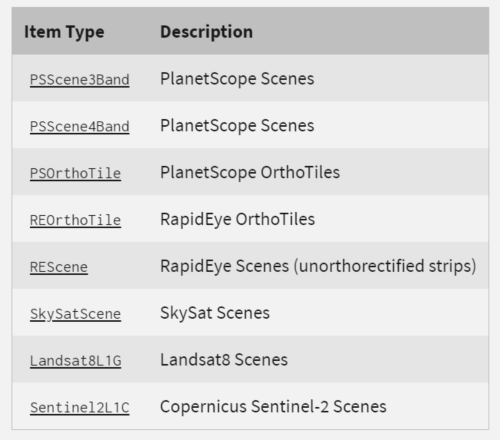

In [30]:
#Review Planet Item Types
Image(r'images/item_types.png')

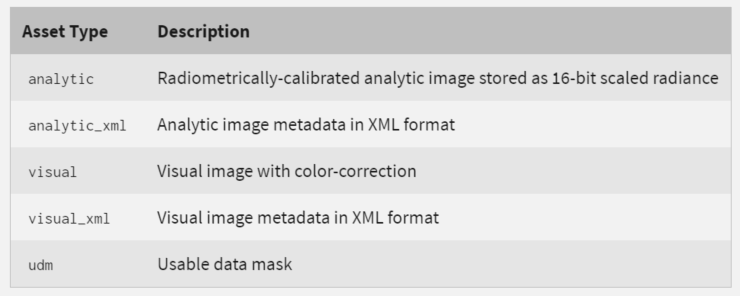

In [31]:
#Review Planet Asset Types
Image(r'images/asset_types.png')

In [13]:
#Creates order defintion (this is the payload that we'll send to the orders v2 api)
def create_order_json(item_ids, item_types, product_bundle, tools, notifications, delivery):
    ''':param item_ids: list of image item ids (List)
    :param item_type: planet image item type (string)
    :param product_bundle: basic, visual, or analytic (string)'''
    
    order_json = {  
                   "name":"simple order",
                   "products":[
                      {  
                         "item_ids":item_ids,
                         "item_type":"PSScene4Band",
                         "product_bundle":product_bundle
                      }
                   ],
                   "tools": tools, 
                   "notifications": notifications,
                   "delivery": delivery
                }
    
    return order_json

**Define Request to Orders V2 API**

Below we are importing a separate script (included in this repo: utilities/post_to_orders_v2.py) that has 3 functions we can call to make a request to the Orders V2 API. This will:

1.) Send a post request to the Orders V2 API that includes our product and operations specifications

2.) Check the Orders V2 response

3.) Download the imagery (only needed if you're not using cloud delivery methods)

In [14]:
#function to send order to V2 API. This function uses an imported script from the utilities folder called post_to_orders_v2.py
def send_to_v2(api_key, payload):
    
    planet_session, results_links = post_to_orders_v2.make_request(api_key, payload)
    download_link, order_name = post_to_orders_v2.check_response(planet_session, results_links)
    
    return planet_session, download_link, order_name

**Run the operation!**

Below we'll specify the final variables we need and run our script. Many of the variables defined below are calling functions we created above. 

In [15]:
'''SEPCIFY ORDERS POST REQUEST VARIABLES'''

#create tools list
bm_equation = "(b4 - b3) / (b4 + b3)"
bm_tool = create_band_math_tool(bm_equation)

clip_tool = define_clip_tool(geom)

tools = []
tools.append(bm_tool)
tools.append(clip_tool)

#create notifications definition
webhook_url = "https://webhook.site/614d7037-47f6-4cf3-9291-3c5524c7fb9d"
notifications = create_web_hook_notification(webhook_url)

#define s3 delivery 
bucket_name = json.load(open(r"tokens\aws_creds.json"))["bucket"]
secret = json.load(open(r"tokens\aws_creds.json"))["secret"]
access = json.load(open(r"tokens\aws_creds.json"))["access"]
delivery = define_delivery(bucket_name, secret, access)

#get order json (payload)
product_bundle = 'analytic'
payload = create_order_json(item_ids, item_types, product_bundle, tools, notifications, delivery)

#send to v2
planet_session, download_link, order_name = send_to_v2(api_key, payload)

making request
8e2bdae0-8e11-4950-9238-d85d9bb22176
['https://api.planet.com/compute/ops/orders/v2/8e2bdae0-8e11-4950-9238-d85d9bb22176']
200
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11-4950-9238-d85d9bb22176
Order state still running 8e2bdae0-8e11

**Display the results!**

We don't actually need to download the images and look at them since they've already been delivered to our S3 bucket! However, for visual sake, let's download the clipped NDVI rasters and plot them with matplotlib. 

In [43]:
#First download the images from S3 to my local comp. 
download_path = os.getcwd()

s3_files = []
downloads = []
for result in download_link:
    if 'bandmath' and '.tif' in result['name']:
        if 'udm' not in result['name']:
            s3_files.append("http://{0}.s3-us-west-2.amazonaws.com/{1}".format(bucket_name, result['name']))
        else:
            pass
        
for link in s3_files:
    r = requests.get(link)
    analytic_tif = download_path + os.path.basename(link)
    with open(analytic_tif, 'wb') as f:
        f.write(r.content)
        
    downloads.append(analytic_tif)
    
print("downloaded {} images".format(len(downloads)))

downloaded 7 images


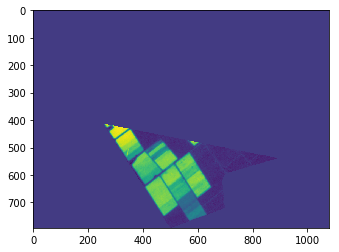

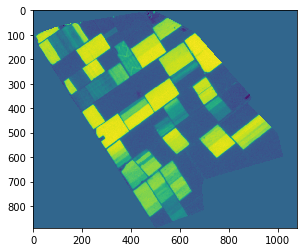

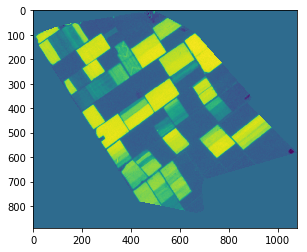

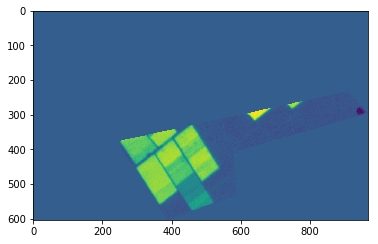

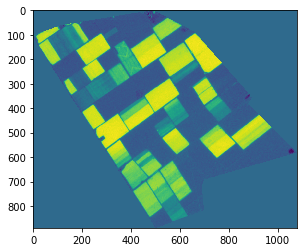

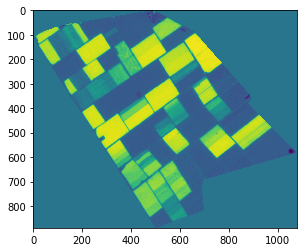

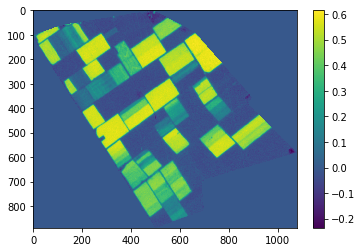

In [42]:
#plot data! 
%matplotlib inline
for raster in downloads:
    gdal_tif = gdal.Open(raster)
    NoneType = type(None)
    if type(gdal_tif) is not NoneType:
        band = gdal_tif.GetRasterBand(1)
        arr = np.array(band.ReadAsArray(), dtype='float_')
        plt.figure()
        plt.imshow(arr)
plt.colorbar();